In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate Synthetic Patient Journeys
np.random.seed(42)
n_patients = 2000

channels = ['Facebook', 'Google Ads', 'Email', 'Direct', 'Organic Search', 'Referral']

paths = [
    "Facebook > Google Ads > Direct",
    "Organic Search > Direct",
    "Email > Facebook > Direct",
    "Google Ads > Direct",
    "Direct",
    "Facebook > Email > Google Ads > Direct",
    "Referral > Organic Search > Direct"
]

data = {
    'Patient_ID': [f'P{5000+i}' for i in range(n_patients)],
    'Journey': np.random.choice(paths, n_patients),
    'Conversion_Value': np.random.uniform(150, 500, n_patients).round(2), # Value of a check-up
    'Cost_Per_Click': np.random.uniform(0.5, 5.0, n_patients).round(2)
}

df_attr = pd.DataFrame(data)
print("Patient Journey Dataset Generated.")
df_attr.head()

Patient Journey Dataset Generated.


,Patient_ID,Journey,Conversion_Value,Cost_Per_Click
0,P5000,Referral > Organic Search > Direct,323.30,3.82
1,P5001,Google Ads > Direct,318.21,2.85
2,P5002,Direct,357.34,0.81
3,P5003,Referral > Organic Search > Direct,438.64,2.17
4,P5004,Email > Facebook > Direct,271.73,4.64


In [49]:
# Helper to split paths
df_attr['Path_List'] = df_attr['Journey'].str.split(' > ')

# 1. First Touch Attribution
df_attr['First_Touch'] = df_attr['Path_List'].apply(lambda x: x[0])

# 2. Last Touch Attribution
df_attr['Last_Touch'] = df_attr['Path_List'].apply(lambda x: x[-1])

# 3. Linear Attribution (Simplified)
# We expand the paths to give a fraction of the value to each channel
linear_rows = []
for idx, row in df_attr.iterrows():
    n_channels = len(row['Path_List'])
    value_per_channel = row['Conversion_Value'] / n_channels
    for channel in row['Path_List']:
        linear_rows.append({'Channel': channel, 'Value': value_per_channel})

df_linear = pd.DataFrame(linear_rows).groupby('Channel').sum().reset_index()

print("Attribution Models Calculated.")

Attribution Models Calculated.


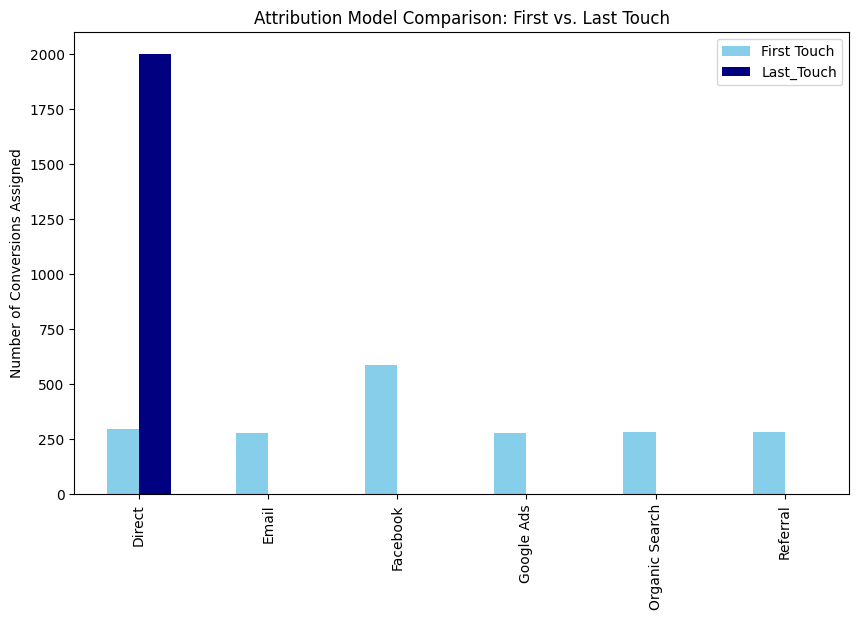

In [50]:
# Compare First vs Last Touch
first_touch_counts = df_attr['First_Touch'].value_counts()
last_touch_counts = df_attr['Last_Touch'].value_counts()

comparison_df = pd.DataFrame({
    'First Touch': first_touch_counts,
    'Last_Touch': last_touch_counts
}).fillna(0)

comparison_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'navy'])
plt.title('Attribution Model Comparison: First vs. Last Touch')
plt.ylabel('Number of Conversions Assigned')
plt.show()

In [51]:
# Calculate Total Value per Channel (Linear Model)
# Assign a mock cost to each channel
channel_costs = {
    'Facebook': 2000,
    'Google Ads': 3500,
    'Email': 500,
    'Direct': 0,
    'Organic Search': 200,
    'Referral': 1000
}

df_linear['Cost'] = df_linear['Channel'].map(channel_costs)
df_linear['ROAS'] = df_linear['Value'] / df_linear['Cost']

# Replace infinity for 'Direct' with 0 for visualization
df_linear.replace([np.inf, -np.inf], 0, inplace=True)

print("Return on Ad Spend (ROAS) by Channel:")
print(df_linear[['Channel', 'Value', 'Cost', 'ROAS']].sort_values(by='ROAS', ascending=False))

Return on Ad Spend (ROAS) by Channel:
          Channel          Value  Cost        ROAS
4  Organic Search   76809.870000   200  384.049350
1           Email   53237.748333   500  106.475497
2        Facebook   86532.505000  2000   43.266253
5        Referral   31283.010000  1000   31.283010
3      Google Ads  100800.731667  3500   28.800209
0          Direct  302457.835000     0    0.000000


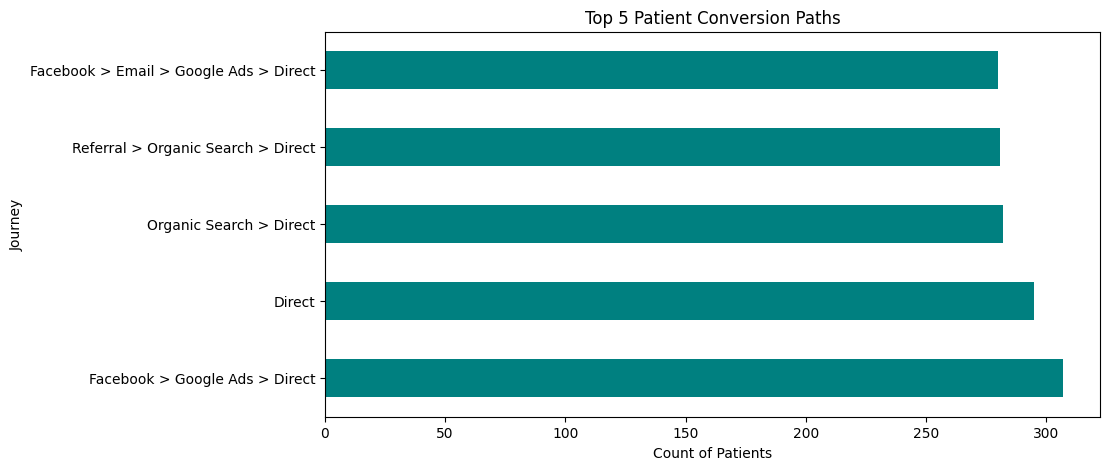

In [52]:
plt.figure(figsize=(10, 5))
df_attr['Journey'].value_counts().head(5).plot(kind='barh', color='teal')
plt.title('Top 5 Patient Conversion Paths')
plt.xlabel('Count of Patients')
plt.show()

In [53]:
top_path = df_attr['Journey'].value_counts().idxmax()
top_roas_channel = df_linear.sort_values(by='ROAS', ascending=False).iloc[0]['Channel']

print(f"Strategic Insight: The most common journey is '{top_path}'.")
print(f"Budget Recommendation: Shift more budget to '{top_roas_channel}' as it provides the highest ROAS.")

Strategic Insight: The most common journey is 'Facebook > Google Ads > Direct'.
Budget Recommendation: Shift more budget to 'Organic Search' as it provides the highest ROAS.
